In [36]:
import sqlite3
import pandas as pd
import plotly.express as px
import plotly.io as pio

target_db = "dft-mot-results-and-test-items-2005-to-2020.sqlite"
con = sqlite3.connect(target_db)

In [89]:
df = pd.read_sql_query("""
    SELECT count(*) AS "Number of MOTs"
    FROM tests
""", con)
df

,Number of MOTs
0,551156643


In [3]:
df = pd.read_sql_query("""
    SELECT count(*) AS "Number of test items"
    FROM test_items
""", con)
df

,Number of test items
0,1031247532


In [2]:
df = pd.read_sql_query("""
    SELECT
        test_types.test_type as "Test type",
        'Class ' || test_class_id as "Test class",
        count(*) AS "Number of tests"
    FROM
        tests
    LEFT JOIN
        test_types ON test_types.type_code = tests.test_type
    GROUP BY
        tests.test_type, tests.test_class_id
    ORDER BY
        tests.test_type, tests.test_class_id
""", con)
df

,Test type,Test class,Number of tests
0,Statutory Appeal,Class 1,9
1,Statutory Appeal,Class 2,26
2,Statutory Appeal,Class 4,1112
3,Statutory Appeal,Class 5,3
4,Statutory Appeal,Class 7,35
5,Normal Test,Class 0,37464
6,Normal Test,Class 1,3704843
7,Normal Test,Class 2,10786397
8,Normal Test,Class 3,185613
9,Normal Test,Class 4,413431243


/Users/michalc/miniconda3/lib/python3.8/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/michalc/miniconda3/lib/python3.8/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



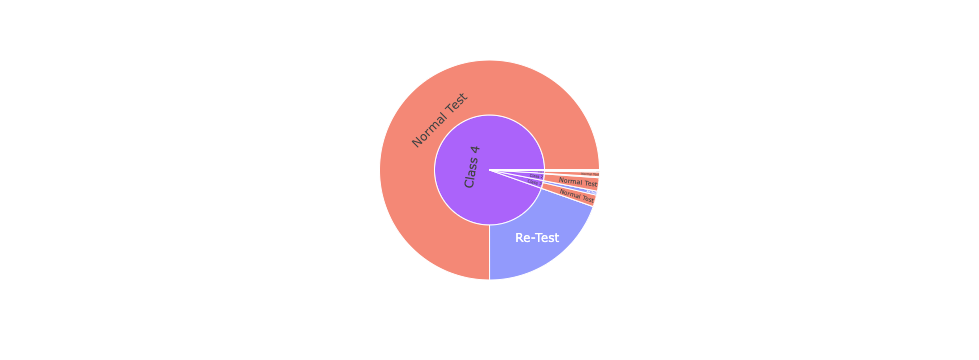

In [35]:
#df.plot.sunburst(y='Number of tests', autopct='%.4f%%')
fig = px.sunburst(
    df.reset_index(),
    path=['Test class', 'Test type'],
    values='Number of tests',
    color='Test type',
    height=300,
)
fig.update_layout({
   'plot_bgcolor': 'rgba(0, 0, 0, 0)',
   'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
pio.write_image(fig, 'subburst.svg', height=775)
fig.show()

In [37]:
df = pd.read_sql_query("""
    SELECT
        count(DISTINCT make) AS "Number of makes"
    FROM
        tests
    WHERE
        test_class_id=4 AND test_type='NT' AND test_result IN ('P', 'PRS', 'F')
        AND test_date LIKE '2020-%'
""", con)
df

,Number of makes
0,6958


In [38]:
# Top 30 makes overall, and top makes of most recent data
df = pd.read_sql_query("""
    SELECT
        make_
    FROM (
        SELECT make_ FROM (
            SELECT
                CASE make 
                   WHEN 'MERCEDES-BENZ' 
                       THEN 'MERCEDES' 
                   ELSE make
                END AS make_
            FROM
                tests
            WHERE
                test_class_id=4 AND test_type='NT' AND test_result IN ('P', 'PRS', 'F')
                AND test_date LIKE '2020-%'
            GROUP BY
                make_
            ORDER BY
                count(*) DESC
            LIMIT
                30
        )
        UNION
        SELECT make_ FROM (
            SELECT
                CASE make 
                   WHEN 'MERCEDES-BENZ' 
                       THEN 'MERCEDES' 
                   ELSE make
                END AS make_
            FROM
                tests
            WHERE
                test_class_id=4 AND test_type='NT' AND test_result IN ('P', 'PRS', 'F')
            GROUP BY
                make_
            ORDER BY
                count(*) DESC
            LIMIT
                30
        )
    )
    ORDER BY
        make_
""", con)
df_top_makes = df
df_top_makes

,make_
0,ALFA ROMEO
1,AUDI
2,BMW
3,CHEVROLET
4,CITROEN
5,DACIA
6,FIAT
7,FORD
8,HONDA
9,HYUNDAI


In [ ]:
df = pd.read_sql_query(f"""
    SELECT
        Year,
        CAST(count(*) FILTER (WHERE make_ NOT IN ({','.join(['?'] * len(df_top_makes))})) AS REAL) / CAST(count(*) AS REAL) AS "Proportion of tests excluded"
    FROM (
        SELECT
            strftime('%Y', test_date) as Year,
            CASE make 
               WHEN 'MERCEDES-BENZ' 
                   THEN 'MERCEDES'
               ELSE make
            END AS make_
        FROM
            tests
        WHERE
            test_class_id=4 AND test_type='NT' AND test_result IN ('P', 'PRS', 'F')
    )
    GROUP BY
        Year
    ORDER BY
        Year
""", con, params=df_top_makes['make_'], index_col='Year')
df

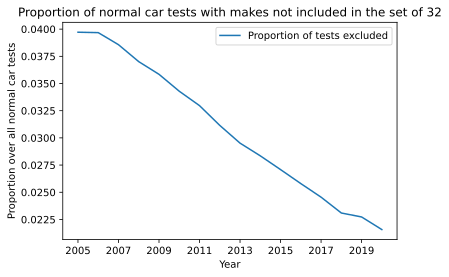

In [35]:
df.plot.line()
ax = plt.gca()
ax.set_title('Proportion of normal car tests with makes not included in the set of 32')
ax.set_ylabel("Proportion over all normal car tests")
plt.savefig("charts/05 - Proportion of test with makes not in 32.svg", bbox_inches="tight")
plt.show()

In [45]:
df = pd.read_sql_query(f"""
    SELECT
        make_ as Make,
        strftime('%Y', test_date) as Year,
        CAST(count(*) FILTER (WHERE test_result = 'F') AS REAL) /
        CAST(count(*) FILTER (WHERE test_result IN ('P', 'PRS', 'F')) AS REAL) AS "Fail rate"
    FROM (
        SELECT
            CASE make 
               WHEN 'MERCEDES-BENZ' 
                   THEN 'MERCEDES'
               ELSE make
            END AS make_,
            test_date,
            test_result
        FROM
            tests
    )
    WHERE
        make_ IN ({','.join(['?'] * len(df_top_makes))})
    GROUP BY
        Make, Year
    ORDER BY
        Make, Year
""", con, params=df_top_makes['make_'])
df

,Make,Year,Fail rate
0,ALFA ROMEO,2005,0.243328
1,ALFA ROMEO,2006,0.238939
2,ALFA ROMEO,2007,0.254227
3,ALFA ROMEO,2008,0.268025
4,ALFA ROMEO,2009,0.278008
...,...,...,...
507,VOLVO,2016,0.219883
508,VOLVO,2017,0.215319
509,VOLVO,2018,0.216502
510,VOLVO,2019,0.209685


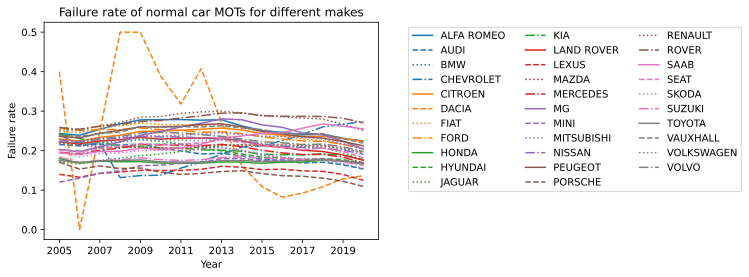

In [66]:
df_pivoted = df.pivot(index='Year', columns='Make', values='Fail rate')

default_cycler = (cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) * cycler(linestyle=['-', '--', ':', '-.']))
ax = plt.gca()
ax.set_prop_cycle(default_cycler)

df_pivoted.plot.line(ax=ax)
ax.set_title('Failure rate of normal car MOTs for different makes')
ax.set_ylabel("Failure rate")
plt.legend(ncol=3, loc="upper right", bbox_to_anchor=(2.1,1))
plt.savefig("charts/06 - Failure rate for makes over time.svg", bbox_inches="tight")
plt.show()

In [72]:
df = pd.read_sql_query(f"""
    SELECT
        make_ as Make,
        CAST(count(*) FILTER (WHERE test_result IN ('P', 'PRS')) AS REAL) /
        CAST(count(*) FILTER (WHERE test_result IN ('P', 'PRS', 'F')) AS REAL) AS "Pass rate"
    FROM (
        SELECT
            CASE make 
               WHEN 'MERCEDES-BENZ' 
                   THEN 'MERCEDES'
               ELSE make
            END AS make_,
            test_date,
            test_result
        FROM
            tests
    )
    WHERE
        make_ IN ({','.join(['?'] * len(df_top_makes))}) AND test_date LIKE '2020-%'
    GROUP BY
        Make
    ORDER BY
        "Pass rate", Make
""", con, params=df_top_makes['make_'], index_col='Make')
df

,Pass rate
Make,
CHEVROLET,0.725487
ROVER,0.729620
SAAB,0.744836
RENAULT,0.749283
ALFA ROMEO,0.775896
CITROEN,0.776274
VAUXHALL,0.781005
PEUGEOT,0.787752
FIAT,0.794158


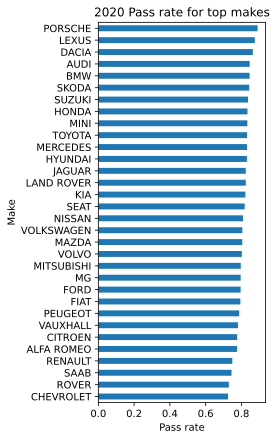

In [87]:
df.plot.barh(figsize=(3,7))
ax = plt.gca()
plt.legend('')
ax.set_title('2020 Pass rate for top makes')
ax.set_xlabel('Pass rate')
ax.legend().set_visible(False)
plt.savefig("charts/06 - 2020 pass rates.svg", bbox_inches="tight")
plt.show()